# Lab 6_2_VAE on CIFAR10

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [ ]:
batch_size = 64
epochs = 5
learning_rate = 1e-3

In [ ]:
# CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))  # Remove or adjust this line
])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:

# VAE model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder (Convolutional layers)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)

        # Latent space
        self.fc1 = nn.Linear(128*4*4, 1024)
        self.fc2_mean = nn.Linear(1024, 256)  # Mean of z
        self.fc2_logvar = nn.Linear(1024, 256)  # Log variance of z

        # Decoder (Deconvolutional layers)
        self.fc3 = nn.Linear(256, 1024)
        self.fc4 = nn.Linear(1024, 128*4*4)

        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)

    def encode(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten the output
        x = torch.relu(self.fc1(x))
        mean = self.fc2_mean(x)
        logvar = self.fc2_logvar(x)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mean + eps*std

    def decode(self, z):
        z = torch.relu(self.fc3(z))
        z = torch.relu(self.fc4(z))
        z = z.view(z.size(0), 128, 4, 4)
        z = torch.relu(self.deconv1(z))
        z = torch.relu(self.deconv2(z))
        z = torch.sigmoid(self.deconv3(z))
        return z

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar

In [ ]:
# Loss function
def loss_function(recon_x, x, mean, logvar):
    # Applying sigmoid activation to the reconstructed image to ensure values are between 0 and 1
    recon_x = torch.sigmoid(recon_x)
    BCE = nn.functional.binary_cross_entropy(recon_x.view(-1, 3*32*32), x.view(-1, 3*32*32), reduction='sum')

    # KL divergence remains the same
    KL = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return BCE + KL

# Training the VAE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Train loop
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mean, logvar = model(data)
        loss = loss_function(recon_batch, data, mean, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f"Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}")

In [ ]:
# Generate random images from the latent space
def generate_images():
    with torch.no_grad():
        sample = torch.randn(64, 256).to(device)
        sample = model.decode(sample).cpu()
        return sample

# Plot generated images
def plot_generated_images():
    generated_images = generate_images()
    fig, axes = plt.subplots(8, 8, figsize=(10, 10))
    for i in range(8):
        for j in range(8):
            axes[i, j].imshow(generated_images[i*8 + j].permute(1, 2, 0).numpy())
            axes[i, j].axis('off')
    plt.show()

Epoch: 1 Average loss: 2082.2823
Epoch: 2 Average loss: 2058.7800
Epoch: 3 Average loss: 2052.1562
Epoch: 4 Average loss: 2045.6806
Epoch: 5 Average loss: 2040.6741


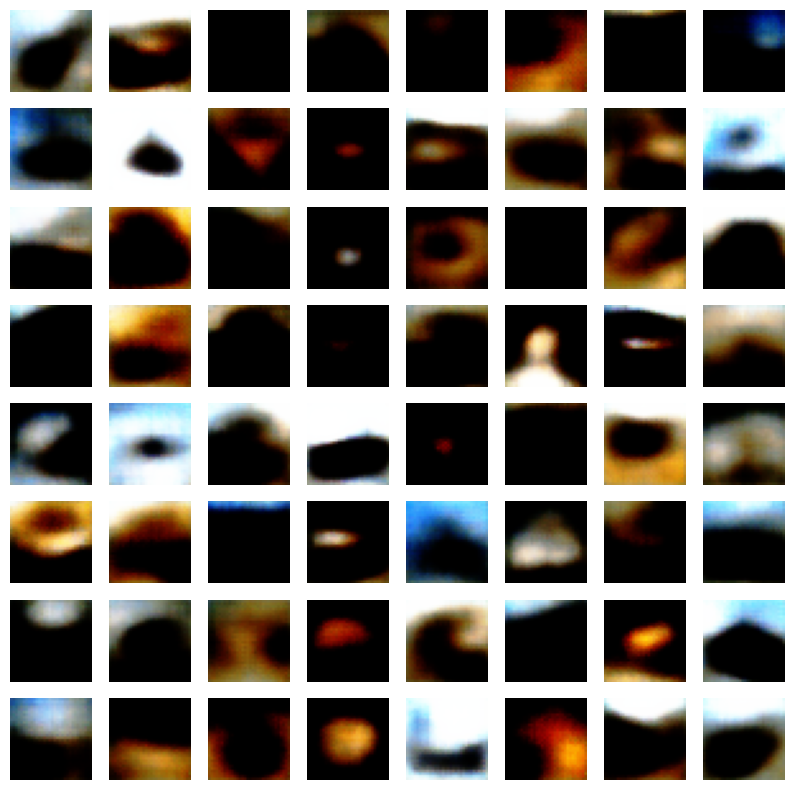

In [ ]:
for epoch in range(1, epochs + 1):
    train(epoch)
    if epoch % 5 == 0:
        plot_generated_images()